In [7]:
!pip install -qU \
    openai \
    pinecone-client \
    langchain \
    langchain-community \
    tiktoken \
    datasets


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from youtube_transcript_api import YouTubeTranscriptApi

def get_video_transcript(video_id):
    """
    Fetch transcript for a given YouTube video ID.
    """
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        transcript_text = " ".join([item['text'] for item in transcript if 'text' in item])
        return transcript_text
    except Exception as e:
        print(f"Error retrieving transcript for video {video_id}: {e}")
        return None

# Example usage with a list of video IDs
video_ids = ['2u4ItZerRac', 'I2zF1I60hPg', '8xqSF-uHCUs', 'LtmS-c1pChY', 'sJNxT-I7L6s']
transcripts = {}

# Fetch the transcript for each video
for video_id in video_ids:
    transcript = get_video_transcript(video_id)
    if transcript:
        transcripts[video_id] = transcript
    else:
        print(f"No transcript available for video {video_id}")

# Display the fetched transcripts
for video_id, transcript in transcripts.items():
    print(f"Transcript for {video_id}:")
    print(transcript[:500])

Transcript for 2u4ItZerRac:
[Music] the pros and cons of living in Germany today we're going to talk about the pros and cons of living in Germany Germany is an amazing country with a strong economy lots of culture great infrastructure and friendly people but that doesn't mean it's the right place for everyone in this video we'll look at all aspects of life in Germany so you can decide if it's the right move for you so let's get started Pros living in Germany is a great experience it offers many advantages both long and sho
Transcript for I2zF1I60hPg:
should you move to Germany that's an easy question to a hard answer but I'm going to try my [Music] best hi my name is Fernando I have been living in Munich Germany for eight years now and yeah I have a lot of experience I say and I'm very happy to kind of like give you some ideas and some stories to will probably help you make a better decision if you should move to Germany or not the first thing of course is that there are many reasons w

In [9]:
from dotenv import load_dotenv, find_dotenv
import os

# Load environment variables from a .env file
_ = load_dotenv(find_dotenv())

# Get API keys from environment variables
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
HUGGINGFACEHUB_API_TOKEN = os.getenv('HUGGINGFACEHUB_API_TOKEN')
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

In [4]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]="Pros&Cons of living in Germany"
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")

In [10]:
from getpass import getpass
from langchain.embeddings.openai import OpenAIEmbeddings

# Get API key for OpenAI
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") or getpass("Enter your OpenAI API key: ")
model_name = 'text-embedding-ada-002'

# Initialize OpenAI Embeddings
embed = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

C:\Users\mehak\AppData\Local\Temp\ipykernel_11764\202383421.py:9: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embed = OpenAIEmbeddings(


In [11]:
from pinecone import Pinecone

# Get API key for Pinecone
api_key = os.getenv("PINECONE_API_KEY") or getpass("Enter your Pinecone API key: ")

# Configure Pinecone client
pc = Pinecone(api_key=api_key)

# Define serverless specification
from pinecone import ServerlessSpec
spec = ServerlessSpec(cloud="aws", region="us-east-1")

In [12]:
import time

index_name = "langchain-retrieval-agent"
existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

# Check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # If does not exist, create index
    pc.create_index(
        index_name,
        dimension=1536,  # Dimensionality of ada 002
        metric='dotproduct',
        spec=spec
    )
    # Wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# Connect to index
index = pc.Index(index_name)
time.sleep(1)
# View index stats
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 5}},
 'total_vector_count': 5}

In [13]:
from tqdm.auto import tqdm

batch_size = 100

# Prepare data for upload to Pinecone
data = [{'title': video_id, 'context': transcript, 'id': video_id} for video_id, transcript in transcripts.items()]

for i in tqdm(range(0, len(data), batch_size)):
    # Get end of batch
    i_end = min(len(data), i + batch_size)
    batch = data[i:i_end]
    # First get metadata fields for this batch
    metadatas = [{'title': record['title'], 'text': record['context']} for record in batch]
    # Get the list of contexts / documents
    documents = [record['context'] for record in batch]
    # Create document embeddings
    embeds = embed.embed_documents(documents)
    # Get IDs
    ids = [record['id'] for record in batch]
    # Add everything to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadatas))

index.describe_index_stats()

  0%|          | 0/1 [00:00<?, ?it/s]

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 5}},
 'total_vector_count': 5}

In [14]:
from langchain.vectorstores import Pinecone

text_field = "text"  # The metadata field that contains our text

# Initialize the vector store object
vectorstore = Pinecone(
    index, embed.embed_query, text_field
)

C:\Users\mehak\AppData\Local\Temp\ipykernel_11764\817828656.py:6: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-pinecone package and should be used instead. To use it run `pip install -U :class:`~langchain-pinecone` and import as `from :class:`~langchain_pinecone import Pinecone``.
  vectorstore = Pinecone(
C:\Users\mehak\AppData\Roaming\Python\Python312\site-packages\langchain_community\vectorstores\pinecone.py:68: UserWarning: Passing in `embedding` as a Callable is deprecated. Please pass in an Embeddings object instead.
  warnings.warn(


In [15]:
query = "what are the pros and cons of living in Germany?"

# Perform similarity search
vectorstore.similarity_search(
    query,  # Our search query
    k=3  # Return 3 most relevant docs
)

[Document(metadata={'title': '2u4ItZerRac'}, page_content="[Music] the pros and cons of living in Germany today we're going to talk about the pros and cons of living in Germany Germany is an amazing country with a strong economy lots of culture great infrastructure and friendly people but that doesn't mean it's the right place for everyone in this video we'll look at all aspects of life in Germany so you can decide if it's the right move for you so let's get started Pros living in Germany is a great experience it offers many advantages both long and shortterm that make it an attractive destination for those considering making the move here are some of the pros of living in Germany one free education for more than 25 years Germany has offered tuition-free higher education at public universities with no charge for most courses and little no cost for administrative fees this means that students coming from all over the world can pursue their degree programs without worrying about expensiv

In [16]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.chains import RetrievalQA

# Chat completion LLM
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-3.5-turbo',
    temperature=0.0
)

# Conversational memory
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

# Retrieval QA chain
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

qa.run(query)

C:\Users\mehak\AppData\Local\Temp\ipykernel_11764\3660127101.py:6: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
C:\Users\mehak\AppData\Local\Temp\ipykernel_11764\3660127101.py:13: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  conversational_memory = ConversationBufferWindowMemory(
C:\Users\mehak\AppData\Local\Temp\ipykernel_11764\3660127101.py:26: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  qa.run(query)


'Pros of living in Germany:\n1. Free education: Germany offers tuition-free higher education at public universities, with grants and scholarships available for living expenses.\n2. Drinkable tap water: Most German towns have high-quality tap water that is monitored stringently.\n3. Unemployment benefits: The German government provides generous provisions for unemployment insurance, including support for education and training.\n4. Punctuality: Germans are known for their punctuality, which can be beneficial for efficient living.\n5. Quality of life: Germany offers a safe environment, low crime rates, cultural offerings, and a high standard of living.\n6. Efficient public transport: Germany has well-developed public transport systems with discounts for students and affordable options for all.\n7. Honesty and reliability: Germans are known for their honesty and reliability in personal and professional interactions.\n\nCons of living in Germany:\n1. Bureaucracy: Dealing with paperwork and

In [17]:
from langchain.agents import Tool

tools = [
    Tool(
        name='Knowledge Base',
        func=qa.run,
        description=(
            'Use this tool when answering general knowledge queries to get '
            'more information about the topic'
        )
    )
]

In [18]:
from langchain.agents import initialize_agent

agent = initialize_agent(
    agent='chat-conversational-react-description',
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method='generate',
    memory=conversational_memory
)

C:\Users\mehak\AppData\Local\Temp\ipykernel_11764\640423283.py:3: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [19]:
agent(query)

C:\Users\mehak\AppData\Local\Temp\ipykernel_11764\4024130983.py:1: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  agent(query)




> Entering new AgentExecutor chain...
```json
{
    "action": "Knowledge Base",
    "action_input": "Pros and cons of living in Germany"
}
```
Observation: Pros of living in Germany:
1. Free education at public universities for more than 25 years.
2. Drinkable tap water in most German towns.
3. Generous unemployment benefits and provisions for unemployment insurance.
4. Punctual culture with a strong emphasis on timeliness.
5. High quality of life with low crime rates and safety measures.
6. Efficient public transport systems with discounts for students and low-income individuals.
7. Germans are known for being fairly honest and reliable.

Cons of living in Germany:
1. Bureaucracy can be overwhelming, especially for newcomers.
2. Difficulty in making friends due to cultural differences and language barriers.
3. Bad customer service in some establishments.
4. Bad internet connection with slow speeds and high prices.
5. Lack of air conditioning in many places, making summers uncomforta

{'input': 'what are the pros and cons of living in Germany?',
 'chat_history': [],
 'output': 'Pros of living in Germany: 1. Free education at public universities for more than 25 years. 2. Drinkable tap water in most German towns. 3. Generous unemployment benefits and provisions for unemployment insurance. 4. Punctual culture with a strong emphasis on timeliness. 5. High quality of life with low crime rates and safety measures. 6. Efficient public transport systems with discounts for students and low-income individuals. 7. Germans are known for being fairly honest and reliable. Cons of living in Germany: 1. Bureaucracy can be overwhelming, especially for newcomers. 2. Difficulty in making friends due to cultural differences and language barriers. 3. Bad customer service in some establishments. 4. Bad internet connection with slow speeds and high prices. 5. Lack of air conditioning in many places, making summers uncomfortable. 6. Tough language to learn, especially for expats starting 

In [20]:
agent("what is the topic of the videos?")



> Entering new AgentExecutor chain...
```json
{
    "action": "Knowledge Base",
    "action_input": "topic of the videos"
}
```
Observation: The videos discussed the pros and cons of living in Germany, the alternative for Germany (AfD) party's radical new approach to immigration policy, and the potential implications of the proposed immigration restrictions in Germany.
Thought:```json
{
    "action": "Final Answer",
    "action_input": "The videos discussed the pros and cons of living in Germany, the alternative for Germany (AfD) party's radical new approach to immigration policy, and the potential implications of the proposed immigration restrictions in Germany."
}
```

> Finished chain.


{'input': 'what is the topic of the videos?',
 'chat_history': [HumanMessage(content='what are the pros and cons of living in Germany?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Pros of living in Germany: 1. Free education at public universities for more than 25 years. 2. Drinkable tap water in most German towns. 3. Generous unemployment benefits and provisions for unemployment insurance. 4. Punctual culture with a strong emphasis on timeliness. 5. High quality of life with low crime rates and safety measures. 6. Efficient public transport systems with discounts for students and low-income individuals. 7. Germans are known for being fairly honest and reliable. Cons of living in Germany: 1. Bureaucracy can be overwhelming, especially for newcomers. 2. Difficulty in making friends due to cultural differences and language barriers. 3. Bad customer service in some establishments. 4. Bad internet connection with slow speeds and high prices. 5. Lack of air conditioni

In [21]:
agent("can you tell me some facts about living in Germany?")



> Entering new AgentExecutor chain...
```json
{
    "action": "Knowledge Base",
    "action_input": "Facts about living in Germany"
}
```
Observation: Living in Germany offers many advantages, such as free education at public universities for more than 25 years, drinkable tap water, unemployment benefits, punctual people, a high quality of life, efficient public transport, and honest and reliable individuals. However, there are also challenges like bureaucracy, difficulty in making friends, bad customer service, bad internet connection, lack of air conditioning, and the tough German language. The country is also facing demographic challenges due to an aging population, leading to a need for skilled immigrants. The government is discussing measures to more easily deport migrants whose asylum applications were rejected or who have committed crimes. Germany is known for its tough stance on migration and deportation, with ongoing debates on how to address these issues effectively.
Though

{'input': 'can you tell me some facts about living in Germany?',
 'chat_history': [HumanMessage(content='what are the pros and cons of living in Germany?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Pros of living in Germany: 1. Free education at public universities for more than 25 years. 2. Drinkable tap water in most German towns. 3. Generous unemployment benefits and provisions for unemployment insurance. 4. Punctual culture with a strong emphasis on timeliness. 5. High quality of life with low crime rates and safety measures. 6. Efficient public transport systems with discounts for students and low-income individuals. 7. Germans are known for being fairly honest and reliable. Cons of living in Germany: 1. Bureaucracy can be overwhelming, especially for newcomers. 2. Difficulty in making friends due to cultural differences and language barriers. 3. Bad customer service in some establishments. 4. Bad internet connection with slow speeds and high prices. 5. Lac

In [22]:
agent("can you summarize these facts in two short sentences")



> Entering new AgentExecutor chain...
```json
{
    "action": "Final Answer",
    "action_input": "Living in Germany offers advantages like free education, reliable public services, and a high quality of life, but challenges include bureaucracy, language barriers, and lack of amenities like air conditioning."
}
```

> Finished chain.


{'input': 'can you summarize these facts in two short sentences',
 'chat_history': [HumanMessage(content='what are the pros and cons of living in Germany?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Pros of living in Germany: 1. Free education at public universities for more than 25 years. 2. Drinkable tap water in most German towns. 3. Generous unemployment benefits and provisions for unemployment insurance. 4. Punctual culture with a strong emphasis on timeliness. 5. High quality of life with low crime rates and safety measures. 6. Efficient public transport systems with discounts for students and low-income individuals. 7. Germans are known for being fairly honest and reliable. Cons of living in Germany: 1. Bureaucracy can be overwhelming, especially for newcomers. 2. Difficulty in making friends due to cultural differences and language barriers. 3. Bad customer service in some establishments. 4. Bad internet connection with slow speeds and high prices. 5. La

In [27]:
agent("can you explain what immigrants faces in germany?")



> Entering new AgentExecutor chain...
```json
{
    "action": "Knowledge Base",
    "action_input": "Challenges faced by immigrants in Germany"
}
```
Observation: Immigrants in Germany face several challenges, including bureaucratic hurdles, difficulties in finding affordable housing, language barriers, discrimination, and difficulties in making friends. The bureaucratic processes in Germany can be complex and time-consuming, making it challenging for immigrants to navigate the system. Additionally, the high cost and limited availability of housing can make it difficult for immigrants to find suitable accommodation. Language barriers can also pose a significant challenge, as German is the primary language spoken in the country. Discrimination, particularly towards people of color, is a problem that some immigrants face. Finally, making friends in Germany can be challenging due to cultural differences and social norms around punctuality and communication.
Thought:```json
{
    "action

{'input': 'can you explain what immigrants faces in germany?',
 'chat_history': [HumanMessage(content='can you summarize these facts in two short sentences', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Living in Germany offers advantages like free education, reliable public services, and a high quality of life, but challenges include bureaucracy, language barriers, and lack of amenities like air conditioning.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='can you explain what immigrants faces in germany?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Immigrants in Germany face challenges such as bureaucratic hurdles, high rental prices, language barriers, discrimination, employment difficulties, social integration issues, high cost of living, limited benefits access, and cultural adaptation.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='what are the benefits of living in germany\n', additional_k

In [29]:
import gradio as gr

def chatbot_response(user_query):
    """
    Function to get response from the agent with dynamic retrieval.
    """
    try:
        # Perform a similarity search to retrieve the most relevant context
        retrieved_docs = vectorstore.similarity_search(user_query, k=3)

        # Get response from the agent
        response = agent.run(user_query)

        # Debugging: Print retrieved documents (Optional)
        print("Retrieved Docs:", [doc.page_content for doc in retrieved_docs])

        return response
    except Exception as e:
        return f"Error: {str(e)}"

# Create Gradio interface
iface = gr.Interface(
    fn=chatbot_response,
    inputs=gr.Textbox(lines=2, placeholder="Ask me about living in Germany..."),
    outputs=gr.Textbox(),
    title="AI Chatbot: Pros & Cons of Living in Germany",
    description="This chatbot retrieves information about living in Germany by analyzing YouTube transcripts. Ask any question!",
    theme="compact"
)

# Launch Gradio app
iface.launch(share=True)

C:\Users\mehak\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py:1050: UserWarning: Cannot load compact. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/compact (Request ID: Root=1-679a67fb-621cc3c26d2ce6d71b0b2be7;83577268-21b3-46bb-8516-70e203df1a27)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


* Running on local URL:  http://127.0.0.1:7869
* Running on public URL: https://64ecf6475e948af819.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)




> Entering new AgentExecutor chain...
```json
{
    "action": "Knowledge Base",
    "action_input": "Challenges faced by people in Germany"
}
```
Observation: Some of the challenges faced by people in Germany include high rent prices, difficulty in finding affordable apartments, making German friends due to the reserved nature of Germans, and navigating the bureaucratic processes, especially when it comes to immigration and paperwork. Additionally, language barriers can be a challenge for newcomers, as German can be a difficult language to learn. The cost of living, especially in cities like Munich, can also be a significant challenge for many residents.
Thought:```json
{
    "action": "Final Answer",
    "action_input": "Some of the challenges faced by people in Germany include high rent prices, difficulty in finding affordable apartments, making German friends due to the reserved nature of Germans, navigating bureaucratic processes, language barriers, and high cost of living."
}
``

trying Evaluation


In [28]:
evaluation_data = [
    {"query": "what is the topic of the videos?","expected": "pros and cons of living in germanyThe pros of living in Germany include free education at public universities, drinkable tap water, generous unemployment benefits, punctuality, high quality of life, efficient public transport, and honesty. On the other hand, the cons include bureaucratic challenges, difficulty in making friends, poor customer service, bad internet connection, lack of air conditioning, language learning difficulty, and high cost of living."},
    {"query": "can you tell me some facts about living in Germany?", "expected": "Living in Germany offers a mix of pros and cons. Some of the pros include free education at public universities, drinkable tap water, unemployment benefits, punctual people, a high quality of life, efficient public transport, and honest and reliable individuals. On the other hand, some cons include bureaucracy, difficulty in making friends, bad customer service, bad internet connection, lack of air conditioning, and the challenge of learning the German language. The country is also facing challenges related to its aging population and the need for skilled immigrants. The government is discussing measures to more easily deport migrants whose asylum applications were rejected or who have committed crimes. The debate on migration is a significant issue in Germany, with discussions on Third Country solutions and the deportation of criminals."},
    {"query": "can you summarize these facts in two short sentences", "expected": "Living in Germany offers benefits like free education, drinkable tap water, and efficient public transport, but challenges include bureaucracy, language barriers, and high cost of living. "},
    {"query": "can you explain what immigrants face in Germany?", "expected": "Living in Germany offers benefits like free education, drinkable tap water, and efficient public transport, but challenges include bureaucracy, language barriers, and high cost of living."},
]

In [29]:
import difflib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data):
    """
    Evaluate the model using the provided data.
    """
    actual_responses = []
    for item in data:
        response = model.run(item["query"])
        actual_responses.append(response)

    # Use difflib to get similarity ratio
    similarities = []
    for actual, expected in zip(actual_responses, [item["expected"] for item in data]):
        similarity = difflib.SequenceMatcher(None, actual, expected).ratio()
        similarities.append(similarity)

    average_similarity = sum(similarities) / len(similarities)
    return {"average_similarity": average_similarity, "similarities": similarities}

# Run evaluation
metrics = evaluate_model(qa, evaluation_data)
print(metrics)

{'average_similarity': 0.1350170416244739, 'similarities': [0.028277634961439587, 0.048477315102548164, 0.38475499092558985, 0.07855822550831792]}


C:\Users\mehak\AppData\Local\Temp\ipykernel_12184\420872856.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


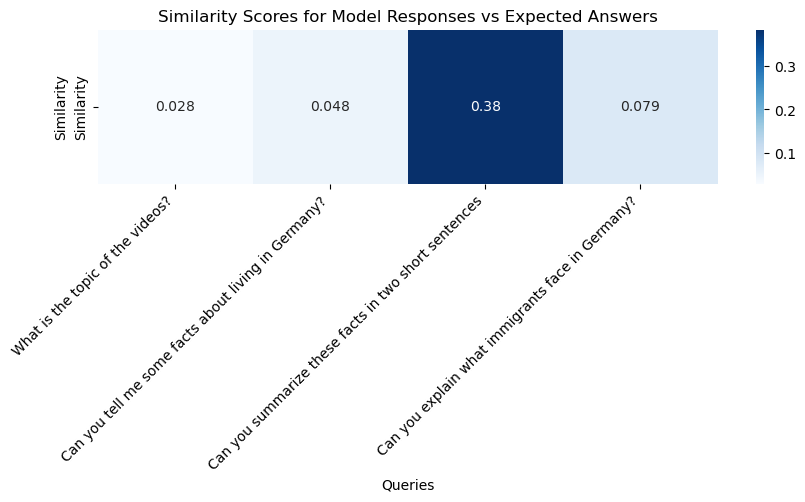

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, f1_score

# Given evaluation results
similarities = [
    0.028277634961439587,  # similarity for "what is the topic of the videos?"
    0.048477315102548164,  # similarity for "can you tell me some facts about living in Germany?"
    0.38475499092558985,   # similarity for "can you summarize these facts in two short sentences"
    0.07855822550831792  # similarity for "can you explain what immigrants face in Germany?"
]

# Query labels corresponding to each similarity
queries = [
    "What is the topic of the videos?",
    "Can you tell me some facts about living in Germany?",
    "Can you summarize these facts in two short sentences",
    "Can you explain what immigrants face in Germany?"
]

# Reshape similarities into a 2D array for plotting (1 row, multiple columns)
similarities_matrix = np.array(similarities).reshape(1, -1)

# Plot the heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(similarities_matrix, annot=True, cmap='Blues', xticklabels=queries, yticklabels=["Similarity"], cbar=True)

# Customize the plot
plt.title('Similarity Scores for Model Responses vs Expected Answers')
plt.xlabel('Queries')
plt.ylabel('Similarity')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

# Define threshold for categorizing as correct (if similarity > 0.5, it's considered a correct match)
threshold = 0.5
predictions = [1 if sim > threshold else 0 for sim in similarities]
# Assuming the expected result is that all queries should be "correct" (1)
true_labels = [1] * len(similarities)  # As we expect all queries to have correct answers
